<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.

# ![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png)  ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# **Web Server Log Analysis with Apache Spark**

This lab will demonstrate how easy it is to perform web server log analysis with Apache Spark.

Server log analysis is an ideal use case for Spark.  It's a very large, common data source and contains a rich set of information.  Spark allows you to store your logs in files on disk cheaply, while still providing a quick and simple way to perform data analysis on them.  This homework will show you how to use Apache Spark on real-world text-based production logs and fully harness the power of that data.  Log data comes from many sources, such as web, file, and compute servers, application logs, user-generated content,  and can be used for monitoring servers, improving business and customer intelligence, building recommendation systems, fraud detection, and much more.

### Homework by 
Mireia Kesti  NIA: 100406960
and
Aleksandra Jamróz NIA: 100491363

## How to complete this lab

This lab is broken up into sections with bite-sized examples for demonstrating Spark functionality for log processing.

It consists of 5 parts:
* *Part 1:* Introduction and Imports
* *Part 2:* Exploratory Data Analysis
* *Part 3*: Analysis Walk-Through on the Web Server Log File
* *Part 4*: Analyzing Web Server Log File
* *Part 5*: Exploring 404 Response Codes

## Aditional Libraries:
To execute this notebook, it will be necessary install two Python libraries:
* *test_helper* provided with the previous laboratory
* *spark_notebook_helpers*: To install this library, you have to go to Workspace -> Users -> Your User -> With right button deply the menu and select **import**. 
    * In the modal dialog, select *"To import a library, such as a jar, or egg, click here"*
    * In Library Source, select PyPI
    * In package introduce "spark_notebook_helpers"
    * Select "Create"

## Part 1: Introduction and Imports

### A note about DataFrame column references

In Python, it's possible to access a DataFrame's columns either by attribute (`df.age`) or by indexing (`df['age']`). Referring to a column by attribute (`df.age`) is very Pandas-like, and it's highly convenient, especially when you're doing interactive data exploration. But it can fail, for reasons that aren't obvious. For example:

In [0]:
throwaway_df = sqlContext.createDataFrame([('Anthony', 10), ('Julia', 20), ('Fred', 5)], ('name', 'count'))
# throwaway_df.select(throwaway_df.count).show() # This line does not work.

To understand why that last line failed, you have to understand how the attribute-column syntax is implemented.

When you type `throwaway_df.count`, Python looks for an _existing_ attribute or method called `count` on the `throwaway_df` object. If it finds one, it uses it. Otherwise, it calls a special Python function (`__getattr__`), which defaults to throwing an exception. Spark has overridden `__getattr__` to look for a column on the DataFrame.

**This means you can only use the attribute (dot) syntax to refer to a column if the DataFrame does not _already_ have an attribute with the column's name.**

In the above example, there's already a `count()` method on the `DataFrame` class, so `throwaway_df.count` does not refer to our "count" column; instead, it refers to the `count()` _method_.

To avoid this problem, you can refer to the column using subscript notation: `throwaway_df['count']`. This syntax will _always_ work.

In [0]:
throwaway_df.select(throwaway_df['count']).show()

+-----+
|count|
+-----+
|   10|
|   20|
|    5|
+-----+



### (1a) Library Imports


We can import standard Python libraries ([modules](https://docs.python.org/2/tutorial/modules.html)) the usual way.  An `import` statement will import the specified module.  In this lab, we will provide any imports that are necessary.

Let's import some of the libraries we'll need:

* `re`: The regular expression library
* `datetime`: Date and time functions
* `Test`: Our Databricks test helper library

In [0]:
import re
import datetime
from test_helper import Test

In [0]:
# Quick test of the regular expression library
m = re.search('(?<=abc)def', 'abcdef')
m.group(0)

Out[4]: 'def'

In [0]:
# Quick test of the datetime library
print ('This was last run on: {0}'.format(datetime.datetime.now()))

This was last run on: 2022-11-05 18:14:28.640200


### (1b) Getting help

Remember: There are some useful Python built-ins for getting help.

You can use Python's [dir()](https://docs.python.org/2/library/functions.html?highlight=dir#dir) function to get a list of all the attributes (including methods) accessible through the `sqlContext` object.

In [0]:
# List sqlContext's attributes
dir(sqlContext)

Out[6]: ['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_conf',
 '_inferSchema',
 '_instantiatedContext',
 '_jsc',
 '_jsqlContext',
 '_jvm',
 '_sc',
 '_ssql_ctx',
 'cacheTable',
 'clearCache',
 'createDataFrame',
 'createExternalTable',
 'dropTempTable',
 'getConf',
 'getOrCreate',
 'newSession',
 'range',
 'read',
 'readStream',
 'registerDataFrameAsTable',
 'registerFunction',
 'registerJavaFunction',
 'setConf',
 'sparkSession',
 'sql',
 'streams',
 'table',
 'tableNames',
 'tables',
 'udf',
 'uncacheTable']

Alternatively, you can use Python's [help()](https://docs.python.org/2/library/functions.html?highlight=help#help) function to get an easier to read list of all the attributes, including examples, that the `sqlContext` object has.

In [0]:
# Use help to obtain more detailed information
help(sqlContext)

Help on SQLContext in module pyspark.sql.context object:

class SQLContext(builtins.object)
 |  SQLContext(sparkContext, sparkSession=None, jsqlContext=None)
 |  
 |  The entry point for working with structured data (rows and columns) in Spark, in Spark 1.x.
 |  
 |  As of Spark 2.0, this is replaced by :class:`SparkSession`. However, we are keeping the class
 |  here for backward compatibility.
 |  
 |  A SQLContext can be used create :class:`DataFrame`, register :class:`DataFrame` as
 |  tables, execute SQL over tables, cache tables, and read parquet files.
 |  
 |  .. deprecated:: 3.0.0
 |      Use :func:`SparkSession.builder.getOrCreate()` instead.
 |  
 |  Parameters
 |  ----------
 |  sparkContext : :class:`SparkContext`
 |      The :class:`SparkContext` backing this SQLContext.
 |  sparkSession : :class:`SparkSession`
 |      The :class:`SparkSession` around which this SQLContext wraps.
 |  jsqlContext : optional
 |      An optional JVM Scala SQLContext. If set, we do not instan

In [0]:
# Help can be used on any Python object
help(map)
help(Test)

Help on class map in module builtins:

class map(object)
 |  map(func, *iterables) --> map object
 |  
 |  Make an iterator that computes the function using arguments from
 |  each of the iterables.  Stops when the shortest iterable is exhausted.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.

Help on class Test in module test_helper.test_helper:

class Test(builtins.object)
 |  Class methods defined here:
 |  
 |  assertEquals(var, val, msg='') from builtins.type
 |  
 |  assertEqualsHashed(var, hashe

## Part 2: Exploratory Data Analysis

Let's begin looking at our data.  For this lab, we will use a data set from NASA Kennedy Space Center web server in Florida. The full data set is freely available at <http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html>, and it contains all HTTP requests for two months. We are using a subset that only contains several days' worth of requests.  The log file has already been downloaded for you.

In [0]:
# Specify path to downloaded log file
import sys
import os

log_file_path = 'dbfs:/' + os.path.join('databricks-datasets', 'cs100', 'lab2', 'data-001', 'apache.access.log.PROJECT')

### (2a) Loading the log file

Now that we have the path to the file, let's load it into a DataFrame. We'll do this in steps. First, we'll use `sqlContext.read.text()` to read the text file. This will produce a DataFrame with a single string column called `value`.

In [0]:
base_df = sqlContext.read.text(log_file_path)
# Let's look at the schema
base_df.printSchema()

root
 |-- value: string (nullable = true)



Let's take a look at some of the data.

In [0]:
base_df.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                          |
+-------------------------------------------------------------------------------------------------------------------------------+
|in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839     |
|uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0                                                        |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0                               |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0                             |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0"

### (2b) Parsing the log file

If you're familiar with web servers at all, you'll recognize that this is in [Common Log Format](https://www.w3.org/Daemon/User/Config/Logging.html#common-logfile-format). The fields are:

_remotehost rfc931 authuser [date] "request" status bytes_

| field         | meaning                                                                |
| ------------- | ---------------------------------------------------------------------- |
| _remotehost_  | Remote hostname (or IP number if DNS hostname is not available).       |
| _rfc931_      | The remote logname of the user. We don't really care about this field. |
| _authuser_    | The username of the remote user, as authenticated by the HTTP server.  |
| _[date]_      | The date and time of the request.                                      |
| _"request"_   | The request, exactly as it came from the browser or client.            |
| _status_      | The HTTP status code the server sent back to the client.               |
| _bytes_       | The number of bytes (`Content-Length`) transferred to the client.      |


Next, we have to parse it into individual columns. We'll use the special built-in [regexp\_extract()](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.regexp_extract)
function to do the parsing. This function matches a column against a regular expression with one or more [capture groups](http://regexone.com/lesson/capturing_groups) and allows you to extract one of the matched groups. We'll use one regular expression for each field we wish to extract.

If you can't read these regular expressions, don't worry. Trust us: They work. If you find regular expressions confusing (and they certainly _can_ be), and you want to learn more about them, start with the
[RegexOne web site](http://regexone.com/). You might also find [_Regular Expressions Cookbook_](http://shop.oreilly.com/product/0636920023630.do), by Jan Goyvaerts and Steven Levithan, to be helpful.

_Some people, when confronted with a problem, think "I know, I'll use regular expressions." Now they have two problems._ (attributed to Jamie Zawinski)

In [0]:
from pyspark.sql.functions import split, regexp_extract
split_df = base_df.select(regexp_extract('value', r'^([^\s]+\s)', 1).alias('host'),
                          regexp_extract('value', r'^.*\[(\d\d/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]', 1).alias('timestamp'),
                          regexp_extract('value', r'^.*"\w+\s+([^\s]+)\s+HTTP.*"', 1).alias('path'),
                          regexp_extract('value', r'^.*"\s+([^\s]+)', 1).cast('integer').alias('status'),
                          regexp_extract('value', r'^.*\s+(\d+)$', 1).cast('integer').alias('content_size'))
split_df.show(truncate=False)

+----------------------------+--------------------------+---------------------------------------------------+------+------------+
|host                        |timestamp                 |path                                               |status|content_size|
+----------------------------+--------------------------+---------------------------------------------------+------+------------+
|in24.inetnebr.com           |01/Aug/1995:00:00:01 -0400|/shuttle/missions/sts-68/news/sts-68-mcc-05.txt    |200   |1839        |
|uplherc.upl.com             |01/Aug/1995:00:00:07 -0400|/                                                  |304   |0           |
|uplherc.upl.com             |01/Aug/1995:00:00:08 -0400|/images/ksclogo-medium.gif                         |304   |0           |
|uplherc.upl.com             |01/Aug/1995:00:00:08 -0400|/images/MOSAIC-logosmall.gif                       |304   |0           |
|uplherc.upl.com             |01/Aug/1995:00:00:08 -0400|/images/USA-logosmall.gif        

### (2c) Data Cleaning

Let's see how well our parsing logic worked. First, let's verify that there are no null rows in the original data set.

In [0]:
base_df.filter(base_df['value'].isNull()).count()

Out[13]: 0

If our parsing worked properly, we'll have no rows with null column values. Let's check.

In [0]:
bad_rows_df = split_df.filter(split_df['host'].isNull() |
                              split_df['timestamp'].isNull() |
                              split_df['path'].isNull() |
                              split_df['status'].isNull() |
                             split_df['content_size'].isNull())
bad_rows_df.count()

Out[14]: 8756

Not good. We have some null values. Something went wrong. Which columns are affected?

(Note: This approach is adapted from an [excellent answer](http://stackoverflow.com/a/33901312) on StackOverflow.)

In [0]:
from pyspark.sql.functions import col, sum

def count_null(col_name):
  return sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
#
# This could be done in one line with a Python list comprehension, but we're keeping
# it simple for those who don't know Python very well.
exprs = []
for col_name in split_df.columns:
  exprs.append(count_null(col_name))

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
split_df.agg(*exprs).show()

+----+---------+----+------+------------+
|host|timestamp|path|status|content_size|
+----+---------+----+------+------------+
|   0|        0|   0|     0|        8756|
+----+---------+----+------+------------+



Okay, they're all in the `content_size` column. Let's see if we can figure out what's wrong. Our original parsing regular expression for that column was:

```
regexp_extract('value', r'^.*\s+(\d+)$', 1).cast('integer').alias('content_size')
```

The `\d+` selects one or more digits at the end of the input line. Is it possible there are lines without a valid content size? Or is there something wrong with our regular expression? Let's see if there are any lines that do not end with one or more digits.

**Note**: In the expression below, `~` means "not".

In [0]:
bad_content_size_df = base_df.filter(~ base_df['value'].rlike(r'\d+$'))
bad_content_size_df.count()

Out[16]: 8756

That's it! The count matches the number of rows in `bad_rows_df` exactly.

Let's take a look at some of the bad column values. Since it's possible that the rows end in extra white space, we'll tack a marker character onto the end of each line, to make it easier to see trailing white space.

In [0]:
from pyspark.sql.functions import lit, concat
bad_content_size_df.select(concat(bad_content_size_df['value'], lit('*'))).show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+
|concat(value, *)                                                                                                            |
+----------------------------------------------------------------------------------------------------------------------------+
|gw1.att.com - - [01/Aug/1995:00:03:53 -0400] "GET /shuttle/missions/sts-73/news HTTP/1.0" 302 -*                            |
|js002.cc.utsunomiya-u.ac.jp - - [01/Aug/1995:00:07:33 -0400] "GET /shuttle/resources/orbiters/discovery.gif HTTP/1.0" 404 -*|
|tia1.eskimo.com - - [01/Aug/1995:00:28:41 -0400] "GET /pub/winvn/release.txt HTTP/1.0" 404 -*                               |
|itws.info.eng.niigata-u.ac.jp - - [01/Aug/1995:00:38:01 -0400] "GET /ksc.html/facts/about_ksc.html HTTP/1.0" 403 -*         |
|grimnet23.idirect.com - - [01/Aug/1995:00:50:12 -0400] "GET /www/software/winvn/winvn.html HTTP/1.0" 404 -*   

Ah. The bad rows correspond to error results, where no content was sent back and the server emitted a "`-`" for the `content_size` field. Since we don't want to discard those rows from our analysis, let's map them to 0.

### (2d) Fix the rows with null content\_size

The easiest solution is to replace the null values in `split_df` with 0. The DataFrame API provides a set of functions and fields specifically designed for working with null values, among them:

* [fillna()](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.fillna), which fills null values with specified non-null values.
* [na](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.na), which returns a [DataFrameNaFunctions](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameNaFunctions) object with many functions for operating on null columns.

We'll use `fillna()`, because it's simple. There are several ways to invoke this function. The easiest is just to replace _all_ null columns with known values. But, for safety, it's better to pass a Python dictionary containing (column\_name, value) mappings. That's what we'll do.

In [0]:
# Replace all null content_size values with 0.
cleaned_df = split_df.na.fill({'content_size': 0})

In [0]:
# Ensure that there are no nulls left.
exprs = []
for col_name in cleaned_df.columns:
  exprs.append(count_null(col_name))

cleaned_df.agg(*exprs).show()

+----+---------+----+------+------------+
|host|timestamp|path|status|content_size|
+----+---------+----+------+------------+
|   0|        0|   0|     0|           0|
+----+---------+----+------+------------+



### (2e) Parsing the timestamp.

Okay, now that we have a clean, parsed DataFrame, we have to parse the timestamp field into an actual timestamp. The Common Log Format time is somewhat non-standard. A [User-Defined Function (UDF)](https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/) is the most straightforward way to parse it.

In [0]:
month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(s):
    """ Convert Common Log time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring time zone here. In a production application, you'd want to handle that.
    return "{0:02d}-{1:02d}-{2:04d} {3:02d}:{4:02d}:{5:02d}".format(
      int(s[7:11]),
      month_map[s[3:6]],
      int(s[0:2]),
      int(s[12:14]),
      int(s[15:17]),
      int(s[18:20])
    )

u_parse_time = udf(parse_clf_time)

logs_df = cleaned_df.select('*', u_parse_time(split_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
total_log_entries = logs_df.count()

In [0]:
logs_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- path: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [0]:
display(logs_df)

host,path,status,content_size,time
in24.inetnebr.com,/shuttle/missions/sts-68/news/sts-68-mcc-05.txt,200,1839,null
uplherc.upl.com,/,304,0,null
uplherc.upl.com,/images/ksclogo-medium.gif,304,0,null
uplherc.upl.com,/images/MOSAIC-logosmall.gif,304,0,null
uplherc.upl.com,/images/USA-logosmall.gif,304,0,null
ix-esc-ca2-07.ix.netcom.com,/images/launch-logo.gif,200,1713,null
uplherc.upl.com,/images/WORLD-logosmall.gif,304,0,null
slppp6.intermind.net,/history/skylab/skylab.html,200,1687,null
piweba4y.prodigy.com,/images/launchmedium.gif,200,11853,null
slppp6.intermind.net,/history/skylab/skylab-small.gif,200,9202,null


Let's cache `logs_df`. We're going to be using it quite a bit from here forward.

In [0]:
logs_df.cache()

Out[23]: DataFrame[host: string, path: string, status: int, content_size: int, time: timestamp]

## Part 3: Analysis Walk-Through on the Web Server Log File

Now that we have a DataFrame containing the parsed log file as a set of Row objects, we can perform various analyses.

### (3a) Example: Content Size Statistics

Let's compute some statistics about the sizes of content being returned by the web server. In particular, we'd like to know what are the average, minimum, and maximum content sizes.

We can compute the statistics by calling `.describe()` on the `content_size` column of `logs_df`.  The `.describe()` function returns the count, mean, stddev, min, and max of a given column.

In [0]:
# Calculate statistics based on the content size.
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.show()

+-------+------------------+
|summary|      content_size|
+-------+------------------+
|  count|           1043177|
|   mean|17531.555702435926|
| stddev| 68561.99906264247|
|    min|                 0|
|    max|           3421948|
+-------+------------------+



Alternatively, we can use SQL to directly calculate these statistics.  You can explore the many useful functions within the `pyspark.sql.functions` module in the [documentation](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions).

After we apply the `.agg()` function, we call `.first()` to extract the first value, which is equivalent to `.take(1)[0]`.

In [0]:
from pyspark.sql import functions as sqlFunctions
content_size_stats =  (logs_df
                       .agg(sqlFunctions.min(logs_df['content_size']),
                            sqlFunctions.avg(logs_df['content_size']),
                            sqlFunctions.max(logs_df['content_size']))
                       .first())

print ('Using SQL functions:')
print ('Content Size Avg: {1:,.2f}; Min: {0:.2f}; Max: {2:,.0f}'.format(*content_size_stats))

Using SQL functions:
Content Size Avg: 17,531.56; Min: 0.00; Max: 3,421,948


### (3b) Example: HTTP Status Analysis

Next, let's look at the status values that appear in the log. We want to know which status values appear in the data and how many times.  We again start with `logs_df`, then group by the `status` column, apply the `.count()` aggregation function, and sort by the `status` column.

In [0]:
status_to_count_df =(logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())

status_to_count_length = status_to_count_df.count()
print ('Found %d response codes' % status_to_count_length)
status_to_count_df.show()

assert status_to_count_length == 7
assert status_to_count_df.take(100) == [(200, 940847), (302, 16244), (304, 79824), (403, 58), (404, 6185), (500, 2), (501, 17)]

Found 7 response codes
+------+------+
|status| count|
+------+------+
|   200|940847|
|   302| 16244|
|   304| 79824|
|   403|    58|
|   404|  6185|
|   500|     2|
|   501|    17|
+------+------+



### (3c) Example: Status Graphing

Now, let's visualize the results from the last example.  We can use the built-in `display()` function to show a bar chart of the count for each response code.  After running this cell, select the bar graph option, and then use "Plot Options..." and drag `status` to the key entry field and drag `count` to the value entry field. See the diagram, below, for an example.

<img src="http://spark-mooc.github.io/web-assets/images/cs105x/plot_options_1.png" style="float: right; margin-right: 30px; border: 1px solid #999999"/>

In [0]:
display(status_to_count_df)

status,count
200,940847
302,16244
304,79824
403,58
404,6185
500,2
501,17


You can see that this is not a very effective plot.  Due to the large number of '200' codes, it is very hard to see the relative number of the others.  We can alleviate this by taking the logarithm of the count, adding that as a column to our DataFrame and displaying the result.

In [0]:
log_status_to_count_df = status_to_count_df.withColumn('log(count)', sqlFunctions.log(status_to_count_df['count']))

display(log_status_to_count_df)

status,count,log(count)
200,940847,13.75453581236166
302,16244,9.69547888880619
304,79824,11.287579490100818
403,58,4.060443010546419
404,6185,8.729882284826589
500,2,0.6931471805599453
501,17,2.833213344056216


While this graph is an improvement, we might want to make more adjustments.  The [`matplotlib` library](http://matplotlib.org/) can give us more control in our plot and is also useful outside the Databricks environment. In this case, we're essentially just reproducing the Databricks graph using `matplotlib`. However, `matplotlib` exposes far more controls than the Databricks graph, allowing you to change colors, label the axes, and more. We're using a set of helper functions from the [`spark_notebook_helpers`](https://pypi.python.org/pypi/spark_notebook_helpers/1.0.1) library.

In [0]:
# np is just an alias for numpy.
# cm and plt are aliases for matplotlib.cm (for "color map") and matplotlib.pyplot, respectively.
# prepareSubplot is a helper.
from spark_notebook_helpers import prepareSubplot, np, plt, cm

In [0]:
help(prepareSubplot)

Help on function prepareSubplot in module spark_notebook_helpers:

prepareSubplot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999', gridWidth=1.0, subplots=(1, 1))
    Template for generating the plot layout.



We're using the "Set1" color map. See the list of Qualitative Color Maps at <http://matplotlib.org/examples/color/colormaps_reference.html> for more details. Feel free to change the color map to a different one, like "Accent".

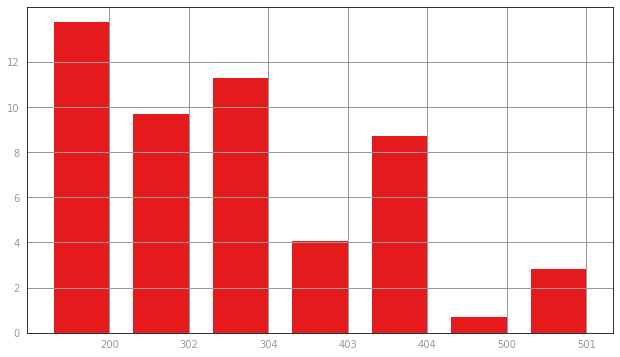

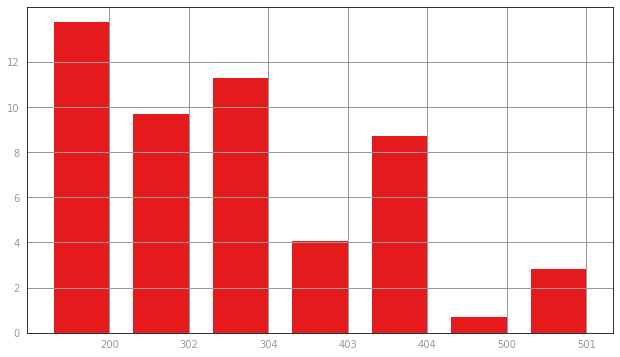

In [0]:
data = log_status_to_count_df.drop('count').collect()
x, y = zip(*data)
index = np.arange(len(x))
bar_width = 0.7
colorMap = 'Set1'
cmap = cm.get_cmap(colorMap)

fig, ax = prepareSubplot(np.arange(0, 6, 1), np.arange(0, 14, 2))
plt.bar(index, y, width=bar_width, color=cmap(0))
plt.xticks(index + bar_width/2.0, x)
display(fig)

### (3d) Example: Frequent Hosts

Let's look at hosts that have accessed the server frequently (e.g., more than ten times). As with the response code analysis in (3b), we create a new DataFrame by grouping `successLogsDF` by the 'host' column and aggregating by count.

We then filter the result based on the count of accesses by each host being greater than ten.  Then, we select the 'host' column and show 20 elements from the result.

In [0]:
# Any hosts that has accessed the server more than 10 times.
host_sum_df =(logs_df
              .groupBy('host')
              .count())

host_more_than_10_df = (host_sum_df
                        .filter(host_sum_df['count'] > 10)
                        .select(host_sum_df['host']))

print ('Any 20 hosts that have accessed more then 10 times:\n')
host_more_than_10_df.show(truncate=False)

Any 20 hosts that have accessed more then 10 times:

+-------------------------------+
|host                           |
+-------------------------------+
|prakinf2.prakinf.tu-ilmenau.de |
|alpha2.csd.uwm.edu             |
|cjc07992.slip.digex.net        |
|n1377004.ksc.nasa.gov          |
|163.205.2.134                  |
|huge.oso.chalmers.se           |
|163.205.44.27                  |
|shark.ksc.nasa.gov             |
|etc5.etechcorp.com             |
|dd07-029.compuserve.com        |
|131.182.101.161                |
|134.95.100.201                 |
|vab08.larc.nasa.gov            |
|ip11.iac.net                   |
|ad11-012.compuserve.com        |
|ad053.du.pipex.com             |
|204.184.6.19                   |
|p8.denver1.dialup.csn.net      |
|gate2.gdc.com                  |
|alcott.acsu.buffalo.edu        |
+-------------------------------+
only showing top 20 rows



### (3e) Example: Visualizing Paths

Now, let's visualize the number of hits to paths (URIs) in the log. To perform this task, we start with our `logs_df` and group by the `path` column, aggregate by count, and sort in descending order.

Next we visualize the results using `matplotlib`. We previously imported the `prepareSubplot` function and the `matplotlib.pyplot` library, so we do not need to import them again.  We extract the paths and the counts, and unpack the resulting list of `Rows` using a `map` function and `lambda` expression.

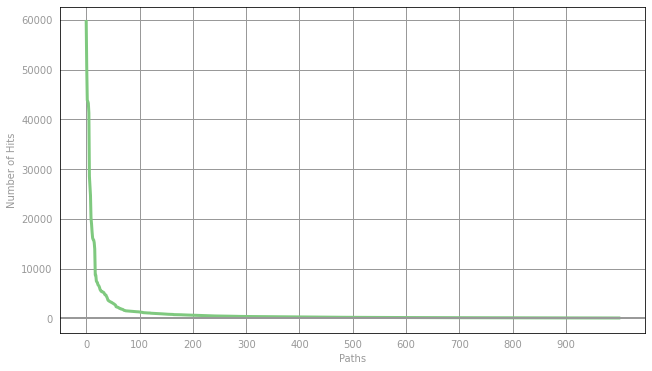

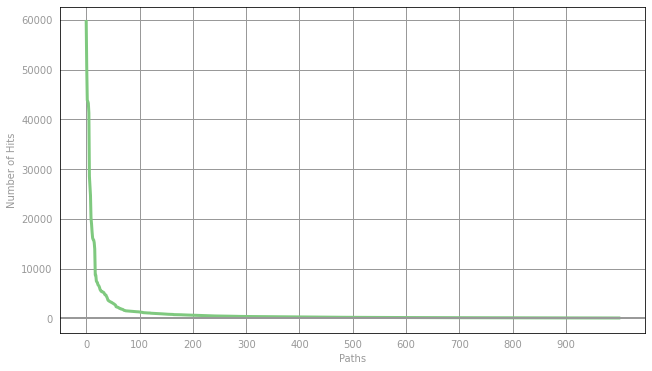

In [0]:
paths_df = (logs_df
            .groupBy('path')
            .count()
            .sort('count', ascending=False))

paths_counts = (paths_df
                .select('path', 'count')
                .rdd
                .map(lambda r: (r[0], r[1]))
                .collect())

paths, counts = zip(*paths_counts)

colorMap = 'Accent'
cmap = cm.get_cmap(colorMap)
index = np.arange(1000)

fig, ax = prepareSubplot(np.arange(0, 1000, 100), np.arange(0, 70000, 10000))
plt.xlabel('Paths')
plt.ylabel('Number of Hits')
plt.plot(index, counts[:1000], color=cmap(0), linewidth=3)
plt.axhline(linewidth=2, color='#999999')
display(fig)

We can also visualize the results as a line graph using the built-in Databricks `display` function to graph the results.  After calling this function on `paths_df`, select the line graph option.

The graph is plotted using the first 1,000 rows of data. To see a more complete plot, click on the "Plot over all results" link. Be prepared to wait a minute or so.

In [0]:
display(paths_df)

path,count
/images/NASA-logosmall.gif,59666
/images/KSC-logosmall.gif,50420
/images/MOSAIC-logosmall.gif,43831
/images/USA-logosmall.gif,43604
/images/WORLD-logosmall.gif,43217
/images/ksclogo-medium.gif,41267
/ksc.html,28536
/history/apollo/images/apollo-logo1.gif,26766
/images/launch-logo.gif,24742
/,20173


### (3f) Example: Top Paths

For the final example, we'll find the top paths (URIs) in the log.  Because we sorted `paths_df` for plotting, all we need to do is call `.show()` and pass in `n=10` and `truncate=False` as the parameters to show the top ten paths without truncating.

In [0]:
# Top Paths
print ('Top Ten Paths:')
paths_df.show(n=10, truncate=False)

expected = [
  (u'/images/NASA-logosmall.gif', 59666),
  (u'/images/KSC-logosmall.gif', 50420),
  (u'/images/MOSAIC-logosmall.gif', 43831),
  (u'/images/USA-logosmall.gif', 43604),
  (u'/images/WORLD-logosmall.gif', 43217),
  (u'/images/ksclogo-medium.gif', 41267),
  (u'/ksc.html', 28536),
  (u'/history/apollo/images/apollo-logo1.gif', 26766),
  (u'/images/launch-logo.gif', 24742),
  (u'/', 20173)
]
assert paths_df.take(10) == expected, 'incorrect Top Ten Paths'

Top Ten Paths:
+---------------------------------------+-----+
|path                                   |count|
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |59666|
|/images/KSC-logosmall.gif              |50420|
|/images/MOSAIC-logosmall.gif           |43831|
|/images/USA-logosmall.gif              |43604|
|/images/WORLD-logosmall.gif            |43217|
|/images/ksclogo-medium.gif             |41267|
|/ksc.html                              |28536|
|/history/apollo/images/apollo-logo1.gif|26766|
|/images/launch-logo.gif                |24742|
|/                                      |20173|
+---------------------------------------+-----+
only showing top 10 rows



### Part 4: Analyzing Web Server Log File

Now it is your turn to perform analyses on the web server log files.

**(4a) Exercise: Top Ten Error Paths**

What are the top ten paths which did not have return code 200? Create a sorted list containing the paths and the number of times that they were accessed with a non-200 return code and show the top ten.

Think about the steps that you need to perform to determine which paths did not have a 200 return code, how you will uniquely count those paths and sort the list.

In [0]:
# Filled in code
# You are welcome to structure your solution in a different way, so long as
# you ensure the variables used in the next Test section are defined

# DataFrame containing all accesses that did not return a code 200
from pyspark.sql.functions import desc
not200DF = logs_df.filter('status<>200') #original code for this line did not work bc of a syntax error. Now it works well.
not200DF.show(10)
# Sorted DataFrame containing all paths and the number of times they were accessed with non-200 return code
logs_sum_df = ( not200DF
               .groupBy('path')
               .count()
               .sort('count', ascending=False))

print ('Top Ten failed URLs:')
logs_sum_df.show(10, False)

+--------------------+--------------------+------+------------+----+
|                host|                path|status|content_size|time|
+--------------------+--------------------+------+------------+----+
|    uplherc.upl.com |                   /|   304|           0|null|
|    uplherc.upl.com |/images/ksclogo-m...|   304|           0|null|
|    uplherc.upl.com |/images/MOSAIC-lo...|   304|           0|null|
|    uplherc.upl.com |/images/USA-logos...|   304|           0|null|
|    uplherc.upl.com |/images/WORLD-log...|   304|           0|null|
|    uplherc.upl.com |/images/NASA-logo...|   304|           0|null|
|kgtyk4.kj.yamagat...|/images/NASA-logo...|   304|           0|null|
|kgtyk4.kj.yamagat...|/images/MOSAIC-lo...|   304|           0|null|
|kgtyk4.kj.yamagat...|/images/USA-logos...|   304|           0|null|
|kgtyk4.kj.yamagat...|/images/WORLD-log...|   304|           0|null|
+--------------------+--------------------+------+------------+----+
only showing top 10 rows

Top Ten 

In [0]:
# TEST Top ten error paths (4a)
top_10_err_urls = [(row[0], row[1]) for row in logs_sum_df.take(10)]
top_10_err_expected = [
  (u'/images/NASA-logosmall.gif', 8761),
  (u'/images/KSC-logosmall.gif', 7236),
  (u'/images/MOSAIC-logosmall.gif', 5197),
  (u'/images/USA-logosmall.gif', 5157),
  (u'/images/WORLD-logosmall.gif', 5020),
  (u'/images/ksclogo-medium.gif', 4728),
  (u'/history/apollo/images/apollo-logo1.gif', 2907),
  (u'/images/launch-logo.gif', 2811),
  (u'/', 2199),
  (u'/images/ksclogosmall.gif', 1622)
]
Test.assertEquals(logs_sum_df.count(), 7675, 'incorrect count for logs_sum_df')
Test.assertEquals(top_10_err_urls, top_10_err_expected, 'incorrect Top Ten failed URLs')

1 test passed.
1 test passed.


### (4b) Exercise: Number of Unique Hosts

How many unique hosts are there in the entire log?

There are multiple ways to find this.  Try to find a more optimal way than grouping by 'host'.

In [0]:
# Filled in code
unique_host_count = logs_df.dropDuplicates(['host']).count()
print ('Unique hosts: {0}'.format(unique_host_count))

Unique hosts: 54507


In [0]:
# TEST Number of unique hosts (4b)
Test.assertEquals(unique_host_count, 54507, 'incorrect unique_host_count')

1 test passed.


### (4c) Exercise: Number of Unique Daily Hosts

For an advanced exercise, let's determine the number of unique hosts in the entire log on a day-by-day basis. This computation will give us counts of the number of unique daily hosts. We'd like a DataFrame sorted by increasing day of the month which includes the day of the month and the associated number of unique hosts for that day. Make sure you cache the resulting DataFrame `daily_hosts_df` so that we can reuse it in the next exercise.

Think about the steps that you need to perform to count the number of different hosts that make requests *each* day.
*Since the log only covers a single month, you can ignore the month.*  You may want to use the [`dayofmonth` function](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.dayofmonth) in the `pyspark.sql.functions` module.

**Description of each variable**

**`day_to_host_pair_df`**

A DataFrame with two columns

| column | explanation          |
| ------ | -------------------- |
| `host` | the host name        |
| `day`  | the day of the month |

There will be one row in this DataFrame for each row in `logs_df`. Essentially, you're just trimming and transforming each row of `logs_df`. For example, for this row in `logs_df`:

```
gw1.att.com - - [23/Aug/1995:00:03:53 -0400] "GET /shuttle/missions/sts-73/news HTTP/1.0" 302 -
```

your `day_to_host_pair_df` should have:

```
gw1.att.com 23
```

**`day_group_hosts_df`**

This DataFrame has the same columns as `day_to_host_pair_df`, but with duplicate (`day`, `host`) rows removed.

**`daily_hosts_df`**

A DataFrame with two columns:

| column  | explanation                                        |
| ------- | -------------------------------------------------- |
| `day`   | the day of the month                               |
| `count` | the number of unique requesting hosts for that day |

In [0]:
# Filled in code --> not entirely correct. 2nd & 3rd tests are failing:
# test 2: incorrect daily_hosts_df.count()
# test 3: incorrect daily_hosts_df

# errors start either here or even before. Thus all the rest of part 4 is not working correctly.


from pyspark.sql.functions import dayofmonth


#option 1 - tests 2 and 3 are failing
""" 
day_to_host_pair_df = logs_df.select(logs_df.host, dayofmonth(logs_df.time).alias('day'))
day_group_hosts_df = day_to_host_pair_df.distinct()
daily_hosts_df = day_group_hosts_df.groupBy('day').count()
daily_hosts_df.cache() # necessary line to pass the last test
"""

# option 2 - tests 2 and 3 are failing
"""
day_to_host_pair_df = logs_df.select('host', dayofmonth('time').alias('day'))
day_group_hosts_df = day_to_host_pair_df.distinct()
daily_hosts_df = day_group_hosts_df.groupBy('day').count().cache()
"""

# option 3 - same error. 
day_to_host_pair_df = logs_df.select(logs_df.host, dayofmonth('time').alias('day'))
day_group_hosts_df = (day_to_host_pair_df
                      .dropDuplicates())
daily_hosts_df = (day_group_hosts_df
                 .groupBy('day')
                  .count().alias('count').cache())

print ('Unique hosts per day:')
daily_hosts_df.show(30, False)

Unique hosts per day:
+----+-----+
|day |count|
+----+-----+
|null|54507|
+----+-----+



In [0]:
# TEST Number of unique daily hosts (4c)
daily_hosts_list = (daily_hosts_df
                    .rdd
                    .map(lambda r: (r[0], r[1]))
                    .take(30))

Test.assertEquals(day_to_host_pair_df.count(), total_log_entries, 'incorrect row count for day_to_host_pair_df')
Test.assertEquals(daily_hosts_df.count(), 21, 'incorrect daily_hosts_df.count()')
Test.assertEquals(daily_hosts_list, [(1, 2582), (3, 3222), (4, 4190), (5, 2502), (6, 2537), (7, 4106), (8, 4406), (9, 4317), (10, 4523), (11, 4346), (12, 2864), (13, 2650), (14, 4454), (15, 4214), (16, 4340), (17, 4385), (18, 4168), (19, 2550), (20, 2560), (21, 4134), (22, 4456)], 'incorrect daily_hosts_df')
Test.assertTrue(daily_hosts_df.is_cached, 'incorrect daily_hosts_df.is_cached')

1 test passed.
1 test failed. incorrect daily_hosts_df.count()
1 test failed. incorrect daily_hosts_df
1 test passed.


### (4d) Exercise: Visualizing the Number of Unique Daily Hosts

Using the results from the previous exercise, we will use `matplotlib` to plot a line graph of the unique hosts requests by day.  We need a list of days called `days_with_hosts` and a list of the number of unique hosts for each corresponding day called `hosts`.

**WARNING**: Simply calling `collect()` on your transformed DataFrame won't work, because `collect()` returns a list of Spark SQL `Row` objects. You must _extract_ the appropriate column values from the `Row` objects. Hint: A loop will help.

In [0]:
# NOT working, tried to alternatives. Neither work
# neither the days nor the hosts are correct 


""" the code to fill in: 
days_with_hosts = <FILL IN>
hosts = <FILL IN>
for <FILL IN>:
  <FILL IN>
""" 

# option 1 - but both tests are failing with this code
""" 
days_with_hosts = []
hosts = []
for day, count in daily_hosts_df.collect():
  days_with_hosts.append(day)
  hosts.append(count)
 """

# option 2 - 
# initially same issue as in the previous lab with the lambda function syntax (bc it again does not want to split the tuple?)
# fixed the syntax error but now getting an AttributeError "'DataFrame' object has no attribute 'map'"
"""
days_with_hosts = daily_hosts_df.map(lambda k,v: k).collect()
hosts = daily_hosts_df.map(lambda k,v :v).collect()
"""

# option 3
days_with_hosts = []
hosts = []
for item in daily_hosts_df.collect():
  days_with_hosts.append(item[0])
  hosts.append(item[1])
print(days_with_hosts)
print(hosts)


print(days_with_hosts)
print(hosts)

[None]
[54507]
[None]
[54507]


In [0]:
# TEST Visualizing unique daily hosts (4d)
test_days = list(range(1, 23))
test_days.remove(2)
Test.assertEquals(days_with_hosts, test_days, 'incorrect days')
Test.assertEquals(hosts, [2582, 3222, 4190, 2502, 2537, 4106, 4406, 4317, 4523, 4346, 2864, 2650, 4454, 4214, 4340, 4385, 4168, 2550, 2560, 4134, 4456], 'incorrect hosts')

1 test failed. incorrect days
1 test failed. incorrect hosts


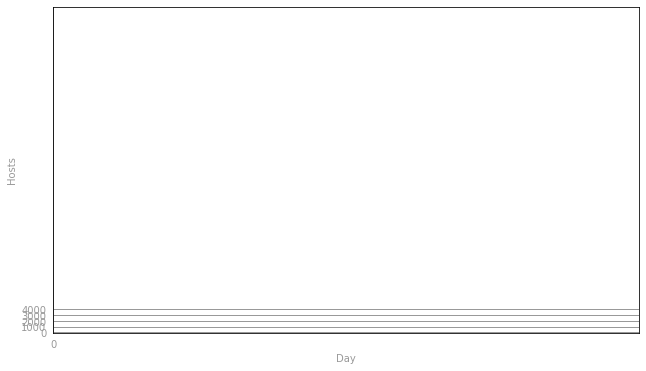

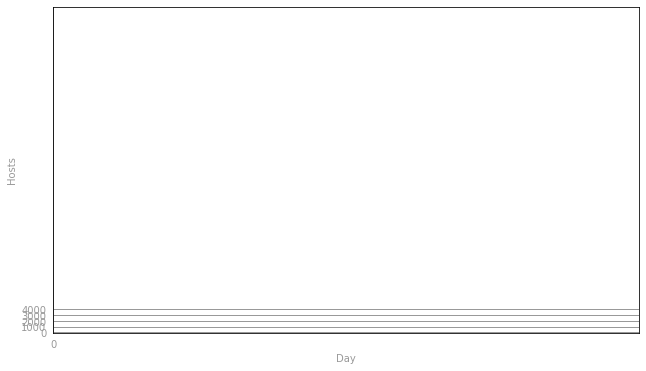

In [0]:
# plot is blank because the code above computing what should be plotted is not working

fig, ax = prepareSubplot(np.arange(0, 30, 5), np.arange(0, 5000, 1000))
colorMap = 'Dark2'
cmap = cm.get_cmap(colorMap)
plt.plot(days_with_hosts, hosts, color=cmap(0), linewidth=3)
plt.axis([0, max(days_with_hosts), 0, max(hosts)+500])
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.axhline(linewidth=3, color='#999999')
plt.axvline(linewidth=2, color='#999999')
display(fig)

You can also pass in the `day_host_count_df` DataFrame into Databricks plots to plot a line or bar graph of the unique hosts requests by day.

In [0]:
display(daily_hosts_df)

day,count
null,54507


### (4e) Exercise: Average Number of Daily Requests per Host

Next, let's determine the average number of requests on a day-by-day basis.  We'd like a list by increasing day of the month and the associated average number of requests per host for that day. Make sure you cache the resulting DataFrame `avg_daily_req_per_host_df` so that we can reuse it in the next exercise.

To compute the average number of requests per host, find the total number of requests per day (across all hosts) and divide that by the number of unique hosts per day (which we found in part 4c and cached as `daily_hosts_df`).

*Since the log only covers a single month, you can skip checking for the month.*

In [0]:
# Filled in code but does not work. 
# It is not computing the avg nº of daily requests per host correctly
# test 1 is thus failing

total_req_per_day_df = logs_df.select(dayofmonth("time").alias("day")).groupBy("day").count()
total_req_per_day_df  = total_req_per_day_df.select(col("day").alias("day"),col("count").alias("total"))

avg_daily_req_per_host_df = (
  total_req_per_day_df.join(daily_hosts_df,'day')).select(total_req_per_day_df["day"],(total_req_per_day_df['total']/daily_hosts_df['count']).alias('avg_reqs_per_host_per_day')).cache()

avg_daily_req_per_host_df.printSchema()
print ('Average number of daily requests per Hosts is:\n')
avg_daily_req_per_host_df.show() 


root
 |-- day: integer (nullable = true)
 |-- avg_reqs_per_host_per_day: double (nullable = true)

Average number of daily requests per Hosts is:

+---+-------------------------+
|day|avg_reqs_per_host_per_day|
+---+-------------------------+
+---+-------------------------+



In [0]:
# TEST Average number of daily requests per hosts (4e)
avg_daily_req_per_host_list = (
  avg_daily_req_per_host_df.select('day', avg_daily_req_per_host_df['avg_reqs_per_host_per_day'].cast('integer').alias('avg_requests'))
                           .collect()
)

values = [(row[0], row[1]) for row in avg_daily_req_per_host_list]
print( values )
Test.assertEquals(values, [(1, 13), (3, 12), (4, 14), (5, 12), (6, 12), (7, 13), (8, 13), (9, 14), (10, 13), (11, 14), (12, 13), (13, 13), (14, 13), (15, 13), (16, 13), (17, 13), (18, 13), (19, 12), (20, 12), (21, 13), (22, 12)], 'incorrect avgDailyReqPerHostDF')
Test.assertTrue(avg_daily_req_per_host_df.is_cached, 'incorrect avg_daily_req_per_host_df.is_cached')

[]
1 test failed. incorrect avgDailyReqPerHostDF
1 test passed.


### (4f) Exercise: Visualizing the Average Daily Requests per Unique Host

Using the result `avg_daily_req_per_host_df` from the previous exercise, use `matplotlib` to plot a line graph of the average daily requests per unique host by day.

`days_with_avg` should be a list of days and `avgs` should be a list of average daily requests (as integers) per unique hosts for each corresponding day.  Hint: You will need to extract these from the Dataframe in a similar way to part 4d.

In [0]:
# Does not compute it correctly. Both tests fail.
# output brackets should not be empty

days_with_avg = []
avgs = []
for item in avg_daily_req_per_host_df.collect():
  days_with_avg.append(item[0])
  avgs.append(item[1])
  
print(days_with_avg)
print(avgs)


[]
[]


In [0]:
# TEST Average Daily Requests per Unique Host (4f)
Test.assertEquals(days_with_avg, [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'incorrect days')
Test.assertEquals([int(a) for a in avgs], [13, 12, 14, 12, 12, 13, 13, 14, 13, 14, 13, 13, 13, 13, 13, 13, 13, 12, 12, 13, 12], 'incorrect avgs')

1 test failed. incorrect days
1 test failed. incorrect avgs


In [0]:
fig, ax = prepareSubplot(np.arange(0, 20, 5), np.arange(0, 16, 2))
colorMap = 'Set3'
cmap = cm.get_cmap(colorMap)
plt.plot(days_with_avg, avgs, color=cmap(0), linewidth=3)
plt.axis([0, max(days_with_avg), 0, max(avgs)+2])
plt.xlabel('Day')
plt.ylabel('Average')
plt.axhline(linewidth=3, color='#999999')
plt.axvline(linewidth=2, color='#999999')
display(fig)

As a comparison to the prior plot, use the Databricks `display` function to plot a line graph of the average daily requests per unique host by day.

In [0]:
# TODO: Replace <FILL IN> with appropriate code
display(<FILL IN>)

## Part 5: Exploring 404 Status Codes

Let's drill down and explore the error 404 status records. We've all seen those "404 Not Found" web pages. 404 errors are returned when the server cannot find the resource (page or object) the browser or client requested.

### (5a) Exercise: Counting 404 Response Codes

Create a DataFrame containing only log records with a 404 status code. Make sure you `cache()` `not_found_df` as we will use it in the rest of this exercise.

How many 404 records are in the log?

In [0]:
# Filled in code. Works well. 

not_found_df = logs_df.filter("status = 404").cache()
print('Found {0} 404 URLs'.format(not_found_df.count()))

Found 6185 404 URLs


In [0]:
# TEST Counting 404 (5a)
Test.assertEquals(not_found_df.count(), 6185, 'incorrect not_found_df.count()')
Test.assertTrue(not_found_df.is_cached, 'incorrect not_found_df.is_cached')

1 test passed.
1 test passed.


### (5b) Exercise: Listing 404 Status Code Records

Using the DataFrame containing only log records with a 404 status code that you cached in part (5a), print out a list up to 40 _distinct_ paths that generate 404 errors.

**No path should appear more than once in your list.**

In [0]:
# Filled in code. Works well. 

not_found_paths_df = not_found_df.select(not_found_df.path)
unique_not_found_paths_df = not_found_paths_df.distinct()

print ('404 URLS:\n')
unique_not_found_paths_df.show(n=40, truncate=False)

404 URLS:

+--------------------------------------------------------+
|path                                                    |
+--------------------------------------------------------+
|/pub/winvn/readme.txt                                   |
|/history/apollo/sa-9/images/                            |
|/history/apollo/sa-1/sa-1-patch-small.gif               |
|/history/apollo/sa-1/docs/                              |
|/elv/DELTA/uncons.htm                                   |
|/history/apollo/a-001/images/                           |
|/history/apollo/a-001/movies/                           |
|/history/apollo/sa-1/movies/                            |
|/nws/public                                             |
|/shuttle/resources/orbiters/atlantis.gif                |
|/IUMA/lib/htu_button.gif                                |
|/history/apollo/html                                    |
|/history/apollo/sa-9/sa-9-patch-small.gif               |
|/history/apollo/a-004/movies/               

In [0]:
# TEST Listing 404 records (5b)

bad_unique_paths_40 = set([row[0] for row in unique_not_found_paths_df.take(40)])
Test.assertEquals(len(bad_unique_paths_40), 40, 'bad_unique_paths_40 not distinct')

1 test passed.


### (5c) Exercise: Listing the Top Twenty 404 Response Code paths

Using the DataFrame containing only log records with a 404 response code that you cached in part (5a), print out a list of the top twenty paths that generate the most 404 errors.

*Remember, top paths should be in sorted order*

In [0]:
# Filled in code. Works well. 

top_20_not_found_df = not_found_paths_df.groupBy("path").count().sort("count", ascending=False)

print ( 'Top Twenty 404 URLs:\n' )
top_20_not_found_df.show(n=20, truncate=False)

Top Twenty 404 URLs:

+-----------------------------------------------------------------+-----+
|path                                                             |count|
+-----------------------------------------------------------------+-----+
|/pub/winvn/readme.txt                                            |633  |
|/pub/winvn/release.txt                                           |494  |
|/shuttle/missions/STS-69/mission-STS-69.html                     |430  |
|/images/nasa-logo.gif                                            |319  |
|/elv/DELTA/uncons.htm                                            |178  |
|/shuttle/missions/sts-68/ksc-upclose.gif                         |154  |
|/history/apollo/sa-1/sa-1-patch-small.gif                        |146  |
|/images/crawlerway-logo.gif                                      |120  |
|/://spacelink.msfc.nasa.gov                                      |117  |
|/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif|100  |
|/history/apollo

In [0]:
# TEST Top twenty 404 URLs (5c)

top_20_not_found = [(row[0], row[1]) for row in top_20_not_found_df.take(20)]
top_20_expected = [
 (u'/pub/winvn/readme.txt', 633),
 (u'/pub/winvn/release.txt', 494),
 (u'/shuttle/missions/STS-69/mission-STS-69.html', 430),
 (u'/images/nasa-logo.gif', 319),
 (u'/elv/DELTA/uncons.htm', 178),
 (u'/shuttle/missions/sts-68/ksc-upclose.gif', 154),
 (u'/history/apollo/sa-1/sa-1-patch-small.gif', 146),
 (u'/images/crawlerway-logo.gif', 120),
 (u'/://spacelink.msfc.nasa.gov', 117),
 (u'/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 100),
 (u'/history/apollo/a-001/a-001-patch-small.gif', 97),
 (u'/images/Nasa-logo.gif', 85),
 (u'', 76),
 (u'/shuttle/resources/orbiters/atlantis.gif', 63),
 (u'/history/apollo/images/little-joe.jpg', 62),
 (u'/images/lf-logo.gif', 59),
 (u'/shuttle/resources/orbiters/discovery.gif', 56),
 (u'/shuttle/resources/orbiters/challenger.gif', 54),
 (u'/robots.txt', 53),
 (u'/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 38)
]
Test.assertEquals(top_20_not_found, top_20_expected, 'incorrect top_20_not_found')

1 test passed.


### (5d) Exercise: Listing the Top Twenty-five 404 Response Code Hosts

Instead of looking at the paths that generated 404 errors, let's look at the hosts that encountered 404 errors. Using the DataFrame containing only log records with a 404 status codes that you cached in part (5a), print out a list of the top twenty-five hosts that generate the most 404 errors.

In [0]:
# Filled in code. Works well. 

hosts_404_count_df = not_found_df.groupBy("host").count().sort("count", ascending=False)

print ( 'Top 25 hosts that generated errors:\n' )
hosts_404_count_df.show(n=25, truncate=False)

Top 25 hosts that generated errors:

+-----------------------------+-----+
|host                         |count|
+-----------------------------+-----+
|maz3.maz.net                 |39   |
|piweba3y.prodigy.com         |39   |
|gate.barr.com                |38   |
|m38-370-9.mit.edu            |37   |
|nexus.mlckew.edu.au          |37   |
|ts8-1.westwood.ts.ucla.edu   |37   |
|204.62.245.32                |33   |
|spica.sci.isas.ac.jp         |27   |
|163.206.104.34               |27   |
|www-d4.proxy.aol.com         |26   |
|www-c4.proxy.aol.com         |25   |
|203.13.168.17                |25   |
|203.13.168.24                |25   |
|internet-gw.watson.ibm.com   |24   |
|piweba5y.prodigy.com         |23   |
|scooter.pa-x.dec.com         |23   |
|crl5.crl.com                 |23   |
|slip145-189.ut.nl.ibm.net    |22   |
|onramp2-9.onr.com            |22   |
|198.40.25.102.sap2.artic.edu |21   |
|gn2.getnet.com               |20   |
|msp1-16.nas.mr.net           |20   |
|dial055.mbne

In [0]:
# TEST Top twenty-five 404 response code hosts (4d)

top_25_404 = [(row[0], row[1]) for row in hosts_404_count_df.take(25)]
Test.assertEquals(len(top_25_404), 25, 'length of errHostsTop25 is not 25')

expected = set([
  (u'maz3.maz.net ', 39),
  (u'piweba3y.prodigy.com ', 39),
  (u'gate.barr.com ', 38),
  (u'nexus.mlckew.edu.au ', 37),
  (u'ts8-1.westwood.ts.ucla.edu ', 37),
  (u'm38-370-9.mit.edu ', 37),
  (u'204.62.245.32 ', 33),
  (u'spica.sci.isas.ac.jp ', 27),
  (u'163.206.104.34 ', 27),
  (u'www-d4.proxy.aol.com ', 26),
  (u'203.13.168.17 ', 25),
  (u'203.13.168.24 ', 25),
  (u'www-c4.proxy.aol.com ', 25),
  (u'internet-gw.watson.ibm.com ', 24),
  (u'crl5.crl.com ', 23),
  (u'piweba5y.prodigy.com ', 23),
  (u'scooter.pa-x.dec.com ', 23),
  (u'onramp2-9.onr.com ', 22),
  (u'slip145-189.ut.nl.ibm.net ', 22),
  (u'198.40.25.102.sap2.artic.edu ', 21),
  (u'msp1-16.nas.mr.net ', 20),
  (u'gn2.getnet.com ', 20),
  (u'tigger.nashscene.com ', 19),
  (u'dial055.mbnet.mb.ca ', 19),
  (u'isou24.vilspa.esa.es ', 19)
])
Test.assertEquals(len(set(top_25_404) - expected), 0, 'incorrect hosts_404_count_df')

1 test passed.
1 test passed.


### (5e) Exercise: Listing 404 Errors per Day

Let's explore the 404 records temporally. Break down the 404 requests by day (cache the `errors_by_date_sorted_df` DataFrame) and get the daily counts sorted by day in `errors_by_date_sorted_df`.

*Since the log only covers a single month, you can ignore the month in your checks.*

In [0]:
# Filled in code. Does not work well
# test 1 failed. incorrect errors_by_date_sorted_df
# test 2 passed.

"""
noticing the same type of error than above in part 4. It seems that the "days" are not working. The count does seem to be computed correctly, but for some reason "day" keeps showing up as "null". This is the reason why everything is failing...
"""

errors_by_date_sorted_df = not_found_df.groupBy(dayofmonth('time').alias('day')).count().sort("day").cache()

print ( '404 Errors by day:\n' )
errors_by_date_sorted_df.show()

404 Errors by day:

+----+-----+
| day|count|
+----+-----+
|null| 6185|
+----+-----+



In [0]:
# TEST 404 response codes per day (5e)

errors_by_date = [(row[0], row[1]) for row in errors_by_date_sorted_df.collect()]
expected = [
  (1, 243),
  (3, 303),
  (4, 346),
  (5, 234),
  (6, 372),
  (7, 532),
  (8, 381),
  (9, 279),
  (10, 314),
  (11, 263),
  (12, 195),
  (13, 216),
  (14, 287),
  (15, 326),
  (16, 258),
  (17, 269),
  (18, 255),
  (19, 207),
  (20, 312),
  (21, 305),
  (22, 288)
]
Test.assertEquals(errors_by_date, expected, 'incorrect errors_by_date_sorted_df')
Test.assertTrue(errors_by_date_sorted_df.is_cached, 'incorrect errors_by_date_sorted_df.is_cached')

1 test failed. incorrect errors_by_date_sorted_df
1 test passed.


### (5f) Exercise: Visualizing the 404 Errors by Day

Using the results from the previous exercise, use `matplotlib` to plot a line or bar graph of the 404 response codes by day.

**Hint**: You'll need to use the same technique you used in (4f).

In [0]:
# TODO: Replace <FILL IN> with appropriate code

days_with_errors_404 = errors_by_date_sorted_df.select("day").flatMap(list).collect()

errors_404_by_day = errors_by_date_sorted_df.select("count").flatMap(list).collect()

print (days_with_errors_404)
print (errors_404_by_day)

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-1281713799711293> in <module>
      1 # TODO: Replace <FILL IN> with appropriate code
      2 
----> 3 days_with_errors_404 = errors_by_date_sorted_df.select("day").flatMap(list).collect()
      4 
      5 errors_404_by_day = errors_by_date_sorted_df.select("count").flatMap(list).collect()

/databricks/spark/python/pyspark/sql/dataframe.py in __getattr__(self, name)
   1798         """
   1799         if name not in self.columns:
-> 1800             raise AttributeError(
   1801                 "'%s' object has no attribute '%s'" % (self.__class__.__name__, name))
   1802         jc = self._jdf.apply(name)

AttributeError: 'DataFrame' object has no attribute 'flatMap'

In [0]:
# TEST Visualizing the 404 Response Codes by Day (4f)
Test.assertEquals(days_with_errors_404, [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'incorrect days_with_errors_404')
Test.assertEquals(errors_404_by_day, [243, 303, 346, 234, 372, 532, 381, 279, 314, 263, 195, 216, 287, 326, 258, 269, 255, 207, 312, 305, 288], 'incorrect errors_404_by_day')

In [0]:
fig, ax = prepareSubplot(np.arange(0, 20, 5), np.arange(0, 600, 100))
colorMap = 'rainbow'
cmap = cm.get_cmap(colorMap)
plt.plot(days_with_errors_404, errors_404_by_day, color=cmap(0), linewidth=3)
plt.axis([0, max(days_with_errors_404), 0, max(errors_404_by_day)])
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.axhline(linewidth=3, color='#999999')
plt.axvline(linewidth=2, color='#999999')
display(fig)

Using the results from exercise (5e), use the Databricks `display` function to plot a line or bar graph of the 404 response codes by day.

In [0]:
display(errors_by_date_sorted_df)

### (5g) Exercise: Top Five Days for 404 Errors

Using the DataFrame `errors_by_date_sorted_df` you cached in the part (5e), what are the top five days for 404 errors and the corresponding counts of 404 errors?

In [0]:
# TODO: Replace <FILL IN> with appropriate code

top_err_date_df = errors_by_date_sorted_df.<FILL IN>

print ('Top Five Dates for 404 Requests:\n')
top_err_date_df.show(5)

In [0]:
# TEST Five dates for 404 requests (4g)

Test.assertEquals([(r[0], r[1]) for r in top_err_date_df.take(5)], [(7, 532), (8, 381), (6, 372), (4, 346), (15, 326)], 'incorrect top_err_date_df')

### (5h) Exercise: Hourly 404 Errors

Using the DataFrame `not_found_df` you cached in the part (5a) and sorting by hour of the day in increasing order, create a DataFrame containing the number of requests that had a 404 return code for each hour of the day (midnight starts at 0). Cache the resulting DataFrame `hour_records_sorted_df` and print that as a list.

In [0]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.sql.functions import hour
hour_records_sorted_df = not_found_df.<FILL IN>

print ('Top hours for 404 requests:\n')
hour_records_sorted_df.show(24)

In [0]:
# TEST Hourly 404 response codes (5h)

errs_by_hour = [(row[0], row[1]) for row in hour_records_sorted_df.collect()]

expected = [
  (0, 175),
  (1, 171),
  (2, 422),
  (3, 272),
  (4, 102),
  (5, 95),
  (6, 93),
  (7, 122),
  (8, 199),
  (9, 185),
  (10, 329),
  (11, 263),
  (12, 438),
  (13, 397),
  (14, 318),
  (15, 347),
  (16, 373),
  (17, 330),
  (18, 268),
  (19, 269),
  (20, 270),
  (21, 241),
  (22, 234),
  (23, 272)
]
Test.assertEquals(errs_by_hour, expected, 'incorrect errs_by_hour')
Test.assertTrue(hour_records_sorted_df.is_cached, 'incorrect hour_records_sorted_df.is_cached')

### (5i) Exercise: Visualizing the 404 Response Codes by Hour

Using the results from the previous exercise, use `matplotlib` to plot a line or bar graph of the 404 response codes by hour.

In [0]:
# TODO: Replace <FILL IN> with appropriate code

hours_with_not_found = <FILL IN>
not_found_counts_per_hour = <FILL IN>

print (hours_with_not_found)
print (not_found_counts_per_hour)

In [0]:
# TEST Visualizing the 404 Response Codes by Hour (5i)
Test.assertEquals(hours_with_not_found, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'incorrect hours_with_not_found')
Test.assertEquals(not_found_counts_per_hour, [175, 171, 422, 272, 102, 95, 93, 122, 199, 185, 329, 263, 438, 397, 318, 347, 373, 330, 268, 269, 270, 241, 234, 272], 'incorrect not_found_counts_per_hour')

In [0]:
fig, ax = prepareSubplot(np.arange(0, 25, 5), np.arange(0, 500, 50))
colorMap = 'seismic'
cmap = cm.get_cmap(colorMap)
plt.plot(hours_with_not_found, not_found_counts_per_hour, color=cmap(0), linewidth=3)
plt.axis([0, max(hours_with_not_found), 0, max(not_found_counts_per_hour)])
plt.xlabel('Hour')
plt.ylabel('404 Errors')
plt.axhline(linewidth=3, color='#999999')
plt.axvline(linewidth=2, color='#999999')
display(fig)

Using the Databricks `display` function and the results from exercise (5h), plot a line or bar graph of the 404 response codes by hour.

In [0]:
display(hour_records_sorted_df)